<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-LMS-Newton-algorithm" data-toc-modified-id="The-LMS-Newton-algorithm-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The LMS-Newton algorithm</a></span><ul class="toc-item"><li><span><a href="#Example-of-aplication:-system-identification" data-toc-modified-id="Example-of-aplication:-system-identification-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Example of aplication: system identification</a></span></li><li><span><a href="#Example-of-aplication:-channel-equalization" data-toc-modified-id="Example-of-aplication:-channel-equalization-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Example of aplication: channel equalization</a></span></li><li><span><a href="#Time-varying-systems" data-toc-modified-id="Time-varying-systems-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Time-varying systems</a></span></li></ul></li><li><span><a href="#The-normalized-LMS-algorithm-(NLMS)" data-toc-modified-id="The-normalized-LMS-algorithm-(NLMS)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The normalized LMS algorithm (NLMS)</a></span></li></ul></div>

In [285]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b master https://github.com/edsonportosilva/adaptive-signal-processing
    from os import chdir as cd
    cd('/content/notebooks/')
    ! pip install -e .
    ! pip install SciencePlots

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [286]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [287]:
from IPython.core.display import HTML
from IPython.display import Image
try:
    import scienceplots
except:
    ! pip install SciencePlots
    
from utils import set_preferences, genConvGIF, symdisp, round_expr

plt.style.use(['science','ieee'])
set_preferences()

plt.rcParams['figure.figsize'] = [5, 2.5]
plt.rcParams['figure.dpi'] = 150

saveFigures = False
figurePath = 'G:\\Meu Drive\\DEE UFCG\\Disciplinas e ementas\\TEEE - Processamento adaptativo de sinais\\lecture notes\\figures\\'

In [288]:
from algorithms import estimate_correlation_matrix, estimate_correlation_matrix, estimate_cross_correlation, lms

# Variantes of LMS algorithm

## The LMS-Newton algorithm

In [307]:
from numba import njit

@njit
def lms_newton(x, d, Ntaps, μ, α):
    """
    The Least Mean Squares (LMS) Newton algorithm.

    Parameters:
        x (ndarray): The input signal.
        d (ndarray): The reference signal.
        Ntaps (int): The number of filter taps.
        μ (float): The LMS step size.
        α (float): The correlation matrix update parameter.

    Returns:
        tuple: A tuple containing:
            - ndarray: The output signal.
            - ndarray: The final filter coefficients.
            - ndarray: The squared error at each iteration.

    """
    # Initialize the equalizer filter coefficients
    h = np.zeros((Ntaps,1), dtype=np.float64) 
    H = np.zeros((len(x)-Ntaps, Ntaps), dtype=np.float64)
    R_inv = 1e-3*np.eye(Ntaps, dtype=np.float64)
       
    # Apply the LMS-Newton algorithm
    ind = np.arange(0,Ntaps)
    squaredError = np.zeros(x.shape, dtype=np.float64)
    out = np.zeros(x.shape, dtype=np.float64)    
    x = x.reshape(-1,1).astype(np.float64)
    
    # Iterate through each sample of the signal
    for i in range(Ntaps, x.shape[0]):
        x_vec = x[i-ind,:]    
              
        # Generate the estimated signal using the equalizer filter
        y = np.sum(x_vec * h)
    
        # Compute the error between the estimated signal and the reference signal
        error = d[i] - y             
        
        # Update inverse correlation matrix      
        R_inv = 1/(1-α)*(R_inv - ( R_inv @ (x_vec@x_vec.T) @ R_inv)/( (1-α)/α + x_vec.T @ R_inv @ x_vec) )
                               
        # Update the filter coefficients using the LMS-Newton update rule
        h += μ * error * R_inv @ x_vec 
        
        squaredError[i] = error**2
        out[i] = y
        H[i-Ntaps,:] = h.T

    return out, h, squaredError, H

### Example of aplication: system identification

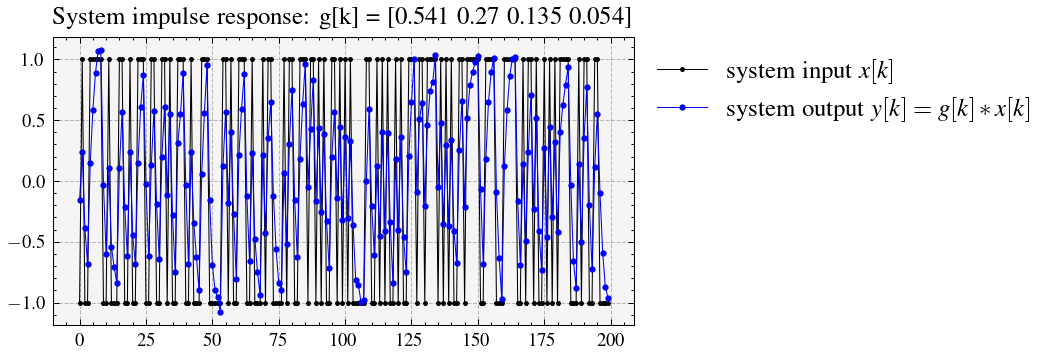

In [290]:
nsamples = 100000
σ2 = 0.0025 # noise variance

# Define input signal to the system
x = 2*np.random.randint(0, 2, nsamples)-1
#x = np.random.normal(0, 1, nsamples)

# Define impulse response of the system
g = np.array([1, 0.5, 0.25, 0.1])
g = g/np.sum(g)

# Convolve input signal with system's impulse response
y = np.convolve(x, g,'same')
y = np.roll(y, 1) # remove input-output delay

# Generate noise and add noise to the systens output
n = np.random.normal(0, np.sqrt(σ2), nsamples)
y += n

plt.plot(x[0:200],'-*k', label='system input $x[k]$')
plt.plot(y[0:200],'-ob', label='system output $y[k] = g[k]\\ast x[k]$');
plt.title(f'System impulse response: g[k] = {g.round(3)}');
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

In [291]:
# Estimate correlation matrix R = E[x*x.T]
R = estimate_correlation_matrix(x, 4)

symdisp('\\boldsymbol{R}_{xx} = ', sp.Matrix(R), numDig=3)

<IPython.core.display.Math object>

In [292]:
# Calculate eigenvalues and eigenvectors associated to R
eigenvalues, eigenvectors = np.linalg.eig(R)

Λ = sp.Matrix(np.diag(eigenvalues))
Q = sp.Matrix(eigenvectors)

print('Matrix of eigenvalues of R:')
symdisp('\\boldsymbol{Λ} = ', Λ, numDig=3)
#symdisp('\\boldsymbol{Q} = ', Q, numDig=3)
#symdisp('\\boldsymbol{R} = \\boldsymbol{Q}\\boldsymbol{Λ}\\boldsymbol{Q}^T = ', Q*Λ*Q.T, numDig=3)

Matrix of eigenvalues of R:


<IPython.core.display.Math object>

In [293]:
# Estimate cross correlation matrix R = E[d*x]
p = estimate_cross_correlation(x, y, 4)

symdisp('\\boldsymbol{p}_{yx} = ', sp.Matrix(p), numDig=3)

h_opt = np.linalg.inv(R)@p
mmse_sys_id = np.mean(y**2) - (h_opt.T)@p

print('Impulse response of the system:')
symdisp('\\boldsymbol{g} = ', sp.Matrix(g), numDig=3)
print('Estimated impulse response of the system :')
symdisp('\\boldsymbol{h}_{opt} =  \\boldsymbol{R}_{xx}^{-1}\\boldsymbol{p}_{yx} =', sp.Matrix(h_opt), numDig=3)
symdisp('\\mathrm{MMSE} = \\mathbb{E}[y^2] - \\boldsymbol{h}_{opt}^{T}\\boldsymbol{p}_{yx} =', sp.Matrix([mmse_sys_id])[0], numDig=3)

<IPython.core.display.Math object>

Impulse response of the system:


<IPython.core.display.Math object>

Estimated impulse response of the system :


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [294]:
# Calculate estimated system output:
y_hat = np.convolve(x, h_opt, 'same')
y_hat = np.roll(y_hat, 1)

mse_estimated = np.mean((y-y_hat)**2)

print('Time averaged MSE:')
symdisp('\\mathrm{MSE} = \\frac{1}{M}\\sum_{i=1}^{M} (y[i]-\\hat{y}[i])^2 =',sp.Matrix([mse_estimated])[0], numDig=3)

Time averaged MSE:


<IPython.core.display.Math object>

In [312]:
μ = 1e-4
α = 0.05
Ntaps = 4

out_lms, h, squaredError_lms, H = lms(x, y, Ntaps, μ)
out_lms_newton, h, squaredError_lms_newton, H = lms_newton(x, y, Ntaps, μ, α)

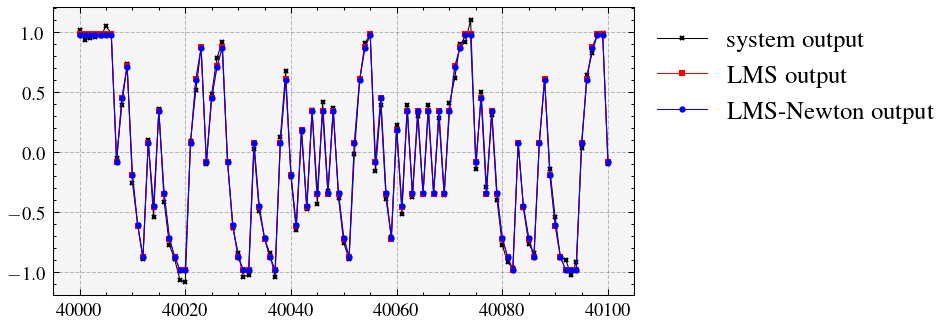

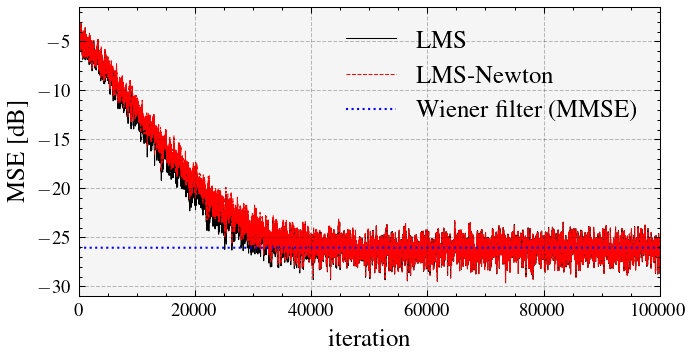

In [313]:
start = 40000
ind = np.arange(start,start+101)

plt.figure()
plt.plot(ind,y[ind],'-xk', label='system output')
plt.plot(ind,out_lms[ind],'-sr', label='LMS output')
plt.plot(ind,out_lms_newton[ind],'-ob', label='LMS-Newton output')
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

average_window_len = 50
mse_lms_dB = 10*np.log10(np.convolve(squaredError_lms,np.ones(average_window_len)/average_window_len, 'same'))
mse_lms_newton_dB = 10*np.log10(np.convolve(squaredError_lms_newton,np.ones(average_window_len)/average_window_len, 'same'))

plt.figure()
plt.plot(mse_lms_dB, label='LMS')
plt.plot(mse_lms_newton_dB, label='LMS-Newton')
plt.plot(10*np.log10(mmse_sys_id)*np.ones(len(mse_lms_dB)), linewidth=1, label=' Wiener filter (MMSE)')
plt.xlim(0,len(mse_lms_dB))
plt.xlabel('iteration')
plt.ylabel('$\\mathrm{MSE}$ [dB]')
plt.legend()
plt.grid();

### Example of aplication: channel equalization

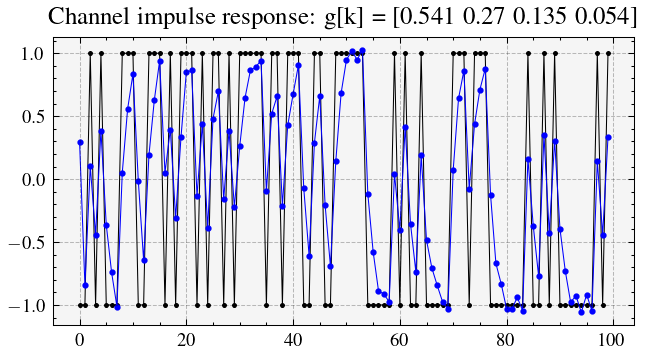

In [314]:
nsamples = 100000
σ2 = 0.0025 # noise variance

# Define input signal to the system
x = 2*np.random.randint(0, 2, nsamples)-1
#x = np.random.normal(0, 1, nsamples)

# Define impulse response of the system
g = np.array([1, 0.5, 0.25, 0.1])
g = g/np.sum(g)

# Convolve input signal with system's impulse response
y = np.convolve(x, g,'same')
y = np.roll(y, 1) # remove input-output delay

# Generate noise and add noise to the systens output
n = np.random.normal(0, np.sqrt(σ2), nsamples)
y += n

plt.plot(x[0:100],'-*k', label='system input')
plt.plot(y[0:100],'-ob', label='system output');
plt.title(f'Channel impulse response: g[k] = {g.round(3)}');

plt.grid()

In [315]:
# Estimate correlation matrix R = E[y*y.T]
R = estimate_correlation_matrix(y, 4)

symdisp('\\boldsymbol{R}_{yy} = ', sp.Matrix(R), numDig=3)

# Calculate eigenvalues and eigenvectors associated to R
eigenvalues, eigenvectors = np.linalg.eig(R)

Λ = sp.Matrix(np.diag(eigenvalues))
Q = sp.Matrix(eigenvectors)

print('Matrix of eigenvalues of R:')
symdisp('\\boldsymbol{Λ} = ', Λ, numDig=3)
# symdisp('\\boldsymbol{Q} = ', Q, numDig=3)
# symdisp('\\boldsymbol{R} = \\boldsymbol{Q}\\boldsymbol{Λ}\\boldsymbol{Q}^T = ', Q*Λ*Q.T, numDig=3)

<IPython.core.display.Math object>

Matrix of eigenvalues of R:


<IPython.core.display.Math object>

In [316]:
# Estimate cross correlation matrix R = E[x*y]
p = estimate_cross_correlation(y, x, 4)

h_opt = np.linalg.inv(R)@p
mmse_ch_eq = np.mean(x**2) - (h_opt.T)@p

print('Impulse response of the channel:')
symdisp('\\boldsymbol{g} = ', sp.Matrix(g), numDig=3)
print('Estimated optimal channel equalizer filter coefficients (Wiener filter):')
symdisp('\\boldsymbol{h}_{opt} =  \\boldsymbol{R}_{yy}^{-1}\\boldsymbol{p}_{xy} =', sp.Matrix(h_opt), numDig=3)
symdisp('\\mathrm{MMSE} = \\mathbb{E}[x^2] - \\boldsymbol{h}_{opt}^{T}\\boldsymbol{p}_{xy} =', sp.Matrix([mmse_ch_eq])[0], numDig=3)

Impulse response of the channel:


<IPython.core.display.Math object>

Estimated optimal channel equalizer filter coefficients (Wiener filter):


<IPython.core.display.Math object>

<IPython.core.display.Math object>

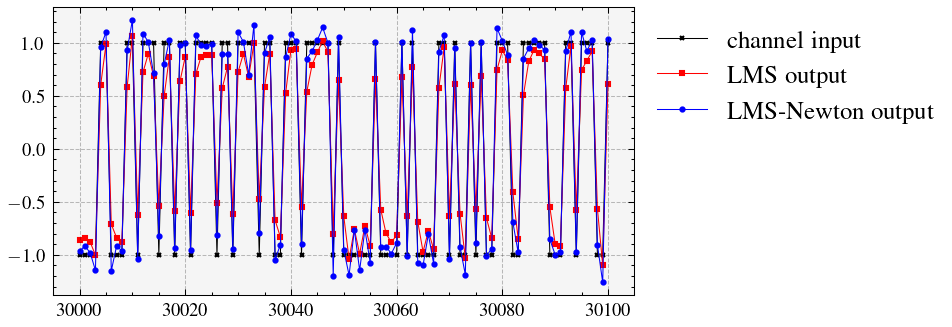

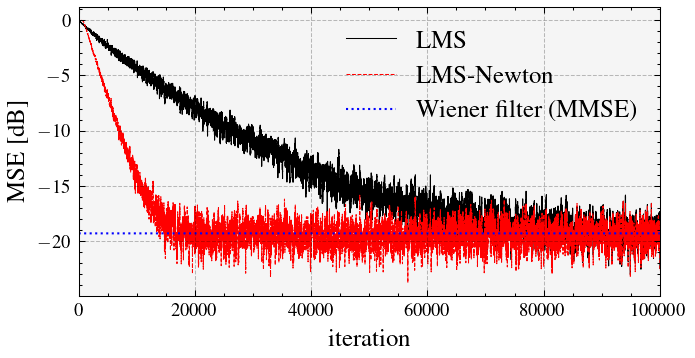

In [318]:
μ = 2e-4
α = 0.01
Ntaps = 4

# Run LMS and LMS-Newton
out_lms, h, squaredError_lms, H = lms(y, x, Ntaps, μ)
out_lms_newton, h, squaredError_lms_newton, H = lms_newton(y, x, Ntaps, μ, α)

start = 30000
ind = np.arange(start,start+101)

# Compare results:
plt.figure()
plt.plot(ind, x[ind],'-xk', label='channel input')
plt.plot(ind,out_lms[ind],'-sr', label='LMS output')
plt.plot(ind,out_lms_newton[ind],'-ob', label='LMS-Newton output')
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

average_window_len = 50
mse_lms_dB = 10*np.log10(np.convolve(squaredError_lms,np.ones(average_window_len)/average_window_len, 'same'))
mse_lms_newton_dB = 10*np.log10(np.convolve(squaredError_lms_newton,np.ones(average_window_len)/average_window_len, 'same'))

plt.figure()
plt.plot(mse_lms_dB, label=' LMS')
plt.plot(mse_lms_newton_dB, label='LMS-Newton')
plt.plot(10*np.log10(mmse_ch_eq)*np.ones(len(mse_lms_dB)), linewidth=1, label='Wiener filter (MMSE)')
plt.xlim(0,len(mse_lms_dB))
plt.xlabel('iteration')
plt.ylabel('$\\mathrm{MSE}$ [dB]')
plt.legend(bbox_to_anchor=(1, 1));
#plt.xlim(0,20000)
plt.grid();

### Time-varying systems

In [301]:
# from algorithms import time_varying_filter
# from utils import random_square_signal

In [302]:
# σ2 = 0.0025 # noise variance
# Ntaps = 4
# H = np.zeros((len(x), Ntaps))

# fh = 100
# fs = 500000
# timeIdx = np.arange(len(x))*(1/fs)

# H[:,0] = 1
# H[:,1] = 0.75 + 0.25*np.sin(2*np.pi*fh*timeIdx + np.pi/67)
# H[:,2] = 0.25 + 0.125*np.cos(2*np.pi*fh*timeIdx + np.pi/13)
# H[:,3] = 0.05 + 0.05*np.sin(2*np.pi*fh*timeIdx + np.pi/77)


# # Time-varying system
# y = time_varying_filter(x, H)

# # Generate noise and add noise to the systens output
# n = np.random.normal(0, np.sqrt(σ2), len(y))
# y += n

# # Run LMS and LMS-Newton
# μ = 1e-3
# α = 2*μ #0.25
# Ntaps = 4

# out_lms, h, squaredError_lms, H_lms = lms(y, x, Ntaps, μ)
# out_lms_newton, h, squaredError_lms_newton, H_lms_newton = lms_newton(y, x, Ntaps, μ, α)

In [303]:
# plt.figure()
# for k in range(Ntaps):
#     plt.plot(H[:,k],label = f'$g_{k}$')
    
# plt.xlabel('k')
# plt.ylabel('Time varying system $\\boldsymbol{g}[k]$')
# plt.legend()
# plt.legend(bbox_to_anchor=(1, 1))
# plt.grid();

# plt.figure()
# for k in range(Ntaps):
#     plt.plot(H_lms[:,k],label = f'$h_{k}$')
    
# plt.xlabel('k')
# plt.ylabel('Adaptive filter $\\boldsymbol{h}[k]$ (LMS)')
# plt.legend()
# plt.legend(bbox_to_anchor=(1, 1))
# plt.grid();

# plt.figure()
# for k in range(Ntaps):
#     plt.plot(H_lms_newton[:,k],label = f'$h_{k}$')
    
# plt.xlabel('k')
# plt.ylabel('Adaptive filter $\\boldsymbol{h}[k]$ (LMS-Newton)')
# plt.legend()
# plt.legend(bbox_to_anchor=(1, 1))
# plt.grid();

# average_window_len = 50
# mse_lms_dB = 10*np.log10(np.convolve(squaredError_lms,np.ones(average_window_len)/average_window_len, 'same'))
# mse_lms_newton_dB = 10*np.log10(np.convolve(squaredError_lms_newton,np.ones(average_window_len)/average_window_len, 'same'))

# plt.figure()
# plt.plot(mse_lms_dB, label=' LMS')
# plt.plot(mse_lms_newton_dB, label='LMS-Newton')
# plt.xlim(0,len(mse_lms_dB))
# plt.xlabel('iteration')
# plt.ylabel('$\\mathrm{MSE}$ [dB]')
# plt.legend(bbox_to_anchor=(1, 1));
# #plt.xlim(0,20000)
# plt.grid();

In [304]:
# start = 0
# ind = np.arange(start,start+20001)

# #plt.plot(ind,x[ind],'-xk', label='channel input', alpha=0.55)
# plt.plot(ind,y[ind],'or', label='channel output', alpha=0.55)
# plt.plot(ind,out_lms[ind],'ok', label='LMS output', alpha=0.55)
# plt.plot(ind,out_lms_newton[ind],'sb', label='LMS-Newton output', alpha=0.55)
# plt.legend(bbox_to_anchor=(1, 1));
# plt.grid()

## The normalized LMS algorithm (NLMS)

In [305]:
from numba import njit

@njit
def nlms(x, d, Ntaps, μ, γ=1e-6):
    """
    The Normalized Least Mean Squares (LMS) Newton algorithm.

    Parameters:
        x (ndarray): The input signal.
        d (ndarray): The reference signal.
        Ntaps (int): The number of filter taps.
        μ (float): The LMS step size.
        γ (float): Parameter to avoid large step sizes when the norm of the input vector is small.

    Returns:
        tuple: A tuple containing:
            - ndarray: The output signal.
            - ndarray: The final filter coefficients.
            - ndarray: The squared error at each iteration.

    """
    # Initialize the equalizer filter coefficients
    h = np.zeros((Ntaps,1), dtype=np.float64) 
    H = np.zeros((len(x)-Ntaps, Ntaps), dtype=np.float64)
    ind = np.arange(0,Ntaps)
   
    # Apply the LMS algorithm
    squaredError = np.zeros(x.shape, dtype=np.float64)
    out = np.zeros(x.shape, dtype=np.float64)    
    x = x.reshape(-1,1).astype(np.float64)
    
    # Iterate through each sample of the signal
    for i in range(Ntaps, x.shape[0]):
        x_vec = x[i-ind,:]    
              
        # Generate the estimated signal using the equalizer filter
        y = np.sum(x_vec * h)
    
        # Compute the error between the estimated signal and the reference signal
        error = d[i] - y             
                              
        # Update the filter coefficients using the LMS update rule
        h += μ * error * x_vec/(γ + x_vec.T@x_vec)
        
        squaredError[i] = error**2
        out[i] = y
        H[i-Ntaps,:] = h.T

    return out, h, squaredError, H

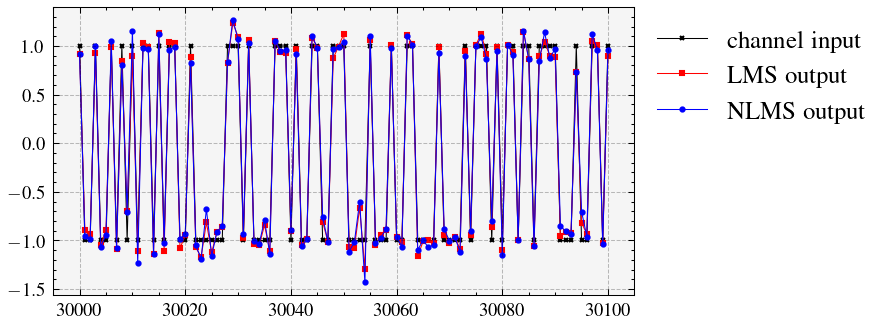

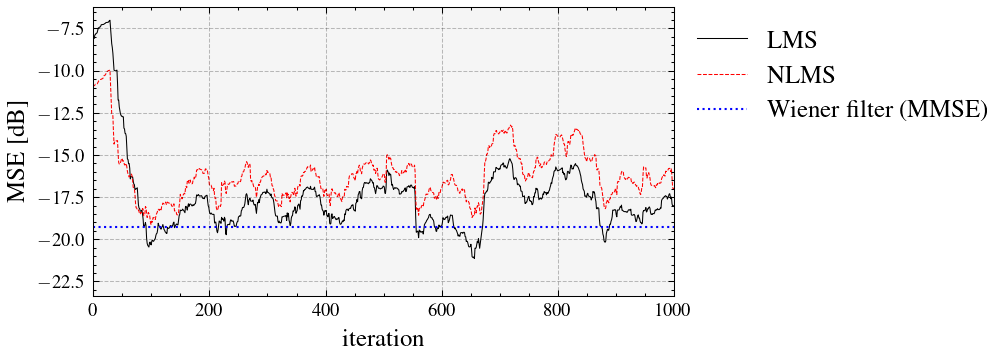

In [306]:
μ_lms = 0.25
μ_nlms = 0.8
Ntaps = 4

# Run LMS and NLMS
out_lms, h, squaredError_lms, H = lms(y, x, Ntaps, μ_lms)
out_nlms, h, squaredError_nlms, H = nlms(y, x, Ntaps, μ_nlms)

start = 30000
ind = np.arange(start,start+101)

# Compare results:
plt.figure()
plt.plot(ind, x[ind],'-xk', label='channel input')
plt.plot(ind,out_lms[ind],'-sr', label='LMS output')
plt.plot(ind,out_nlms[ind],'-ob', label='NLMS output')
plt.legend(bbox_to_anchor=(1, 1));
plt.grid()

average_window_len = 50
mse_lms_dB = 10*np.log10(np.convolve(squaredError_lms,np.ones(average_window_len)/average_window_len, 'same'))
mse_nlms_dB = 10*np.log10(np.convolve(squaredError_nlms,np.ones(average_window_len)/average_window_len, 'same'))

plt.figure()
plt.plot(mse_lms_dB, label=' LMS')
plt.plot(mse_nlms_dB, label='NLMS')
plt.plot(10*np.log10(mmse_ch_eq)*np.ones(len(mse_lms_dB)), linewidth=1, label='Wiener filter (MMSE)')
plt.xlim(0,len(mse_lms_dB))
plt.xlabel('iteration')
plt.ylabel('$\\mathrm{MSE}$ [dB]')
plt.legend(bbox_to_anchor=(1, 1));
plt.xlim(0,1000)
plt.grid();